In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
! pip install -r requirements.txt

Obtaining file:///Users/satwik/code/never_see_you_again/codementor/ongoing/alexey/gym (from -r requirements.txt (line 1))
  Attempting uninstall: gym
    Found existing installation: gym 0.18.0
    Uninstalling gym-0.18.0:
      Successfully uninstalled gym-0.18.0
  Running setup.py develop for gym
You should consider upgrading via the '/Users/satwik/.pyenv/versions/3.6.9/bin/python3.6 -m pip install --upgrade pip' command.


In [3]:
import gym
from IPython.display import clear_output
import matplotlib.pyplot as plt
import numpy as np

from collections import deque, Counter, defaultdict
import pickle
import random
from time import sleep

In [4]:
env = gym.make('DualTaxi-v1')
env.render()

Total encoded states are 6144
+-------+
|R: | :G|
| : | : |
| | : : |
|Y: |B: |
+-------+



In [5]:
def bellman_update(q_table, state, action, next_state, reward):
    old_q_value = q_table[state, action]
    # Maximum q_value for the actions in next state
    next_max = np.max(q_table[next_state])
    # Calculate the new q_value
    new_q_value = (1 - alpha) * old_q_value + alpha * (reward + gamma * next_max)
    # Finally, update the q_value
    q_table[state, action] = new_q_value


def update(q_table, env, state):
    if random.uniform(0, 1) > epsilon:
        action = env.action_space.sample()
    else:
        action = np.argmax(q_table[state])

    next_state, reward, done, info = env.step(action)
    bellman_update(q_table, state, action, next_state, reward)
    return next_state, reward, done, info


def train_agent(
        q_table, env, num_episodes, log_every=50000, running_metrics_len=50000,
        evaluate_every=1000, evaluate_trials=200):
    
    rewards = deque(maxlen=running_metrics_len)
    episode_lengths = deque(maxlen=50)
    total_timesteps = 0
    
    metrics = {}
    
    for i in range(num_episodes):
        epochs = 0
        state = env.reset()
        num_penalties, reward= 0, 0
        done = False
    
        while not done:
            state, reward, done, info = update(q_table, env, state)
            rewards.append(reward)
            epochs += 1
            total_timesteps += 1
            
            if total_timesteps % log_every == 0:
                rd = Counter(rewards)
                avg_ep_len = np.mean(episode_lengths)
                zeroes, fill_percent = calculate_q_table_metrics(q_table)
                print(f'Current Episode: {i}')
                print(f'Reward distribution: {rd}')
                print(f'Last 10 episode lengths (avg: {avg_ep_len})')
                print(f'{zeroes} Q table zeroes, {fill_percent} percent filled')
                

        episode_lengths.append(epochs)
        
        if i % evaluate_every == 0:
            print('===' * 10)
            print(f"Running evaluation after {i} episodes")
            finish_percent, avg_time, penalties = evaluate_agent(q_table, env, evaluate_trials)
            print('===' * 10)
            rd = Counter(rewards)
            avg_ep_len = float(np.mean(episode_lengths))
            zeroes, fill_percent = calculate_q_table_metrics(q_table)
            
            metrics[i] = {
                    'train_reward_distribution': rd,
                    'train_ep_len': avg_ep_len,
                    'fill_percent': fill_percent,
                    'test_finish_percent': finish_percent,
                    'test_ep_len': avg_time,
                    'test_penalties': penalties
            }
        
    print("Training finished.")
    return q_table, metrics

def calculate_q_table_metrics(grid):
    r, c = grid.shape
    total = r * c
    count = 0
    for row in grid:
        for cell in row:
            if cell == 0:
                count += 1
    fill_percent = (total - count) / total * 100.0
    return count, fill_percent

def evaluate_agent(q_table, env, num_trials):
    total_epochs, total_penalties, total_wins = 0, 0, 0
    for _ in range(num_trials):
        state = env.reset()
        epochs, num_penalties, wins = 0, 0, 0
        done = False
        while not done:
            next_action = np.argmax(q_table[state])
            state, reward, done, _ = env.step(next_action)
            if reward < -2:
                num_penalties += 1
            elif reward > 10:
                wins += 1
            epochs += 1
        total_epochs += epochs
        total_penalties += num_penalties
        total_wins += wins

    average_penalties, average_time, complete_percent = compute_evaluation_metrics(num_trials,total_epochs,total_penalties,total_wins)
    print_evaluation_metrics(average_penalties,average_time,num_trials,total_wins)
    return complete_percent, average_time, average_penalties

def print_evaluation_metrics(average_penalties, average_time, num_trials, total_wins):
    print("Evaluation results after {} trials".format(num_trials))
    print("Average time steps taken: {}".format(average_time))
    print("Average number of penalties incurred: {}".format(average_penalties))
    print(f"Had {total_wins} wins in {num_trials} episodes")

def compute_evaluation_metrics(num_trials, total_epochs, total_penalties, total_wins):
    average_time = total_epochs / float(num_trials)
    average_penalties = total_penalties / float(num_trials)
    complete_percent = total_wins / num_trials * 100.0
    return average_penalties, average_time, complete_percent

def plot_metrics(m):
    ep_nums = list(m.keys())
    series = defaultdict(list)
    for ep_num, metrics in m.items():
        for metric_name, metric_val in metrics.items():
            t = type(metric_val)
            if t in [float, int, np.float64]:
                series[metric_name].append(metric_val)

    for m_name, values in series.items():
        plt.plot(ep_nums, values)
        plt.title(m_name)
        plt.show()

Total encoded states are 6144
Running evaluation after 0 episodes
Evaluation results after 200 trials
Average time steps taken: 1500.0
Average number of penalties incurred: 1500.0
Had 0 wins in 200 episodes
Current Episode: 81
Reward distribution: Counter({-4: 17743, -12: 15638, -3: 7711, -20: 4140, -11: 2212, -30: 1924, -2: 388, -10: 175, 99: 46, 90: 23})
Last 10 episode lengths (avg: 513.72)
180756 Q table zeroes, 18.277994791666664 percent filled
Current Episode: 164
Reward distribution: Counter({-12: 16509, -4: 16415, -3: 7783, -20: 4092, -11: 2604, -30: 1947, -2: 375, -10: 200, 99: 51, 90: 24})
Last 10 episode lengths (avg: 604.66)
148739 Q table zeroes, 32.753273292824076 percent filled
Current Episode: 270
Reward distribution: Counter({-12: 17040, -4: 16604, -3: 6858, -20: 4253, -11: 2430, -30: 2157, -2: 379, -10: 178, 99: 74, 90: 27})
Last 10 episode lengths (avg: 427.04)
122434 Q table zeroes, 44.6460865162037 percent filled
Current Episode: 368
Reward distribution: Counter({-

Evaluation results after 200 trials
Average time steps taken: 888.47
Average number of penalties incurred: 885.145
Had 82 wins in 200 episodes
Current Episode: 7476
Reward distribution: Counter({-4: 15705, -12: 13449, -3: 10653, -20: 4206, -11: 2930, -30: 1581, -2: 841, 99: 373, -10: 132, 90: 130})
Last 10 episode lengths (avg: 74.68)
49647 Q table zeroes, 77.55398220486111 percent filled
Current Episode: 7990
Reward distribution: Counter({-4: 16589, -12: 14089, -3: 9590, -20: 4086, -11: 2686, -30: 1526, -2: 804, 99: 382, -10: 131, 90: 117})
Last 10 episode lengths (avg: 90.12)
49495 Q table zeroes, 77.62270326967592 percent filled
Running evaluation after 8000 episodes
Evaluation results after 200 trials
Average time steps taken: 932.965
Average number of penalties incurred: 928.44
Had 76 wins in 200 episodes
Current Episode: 8557
Reward distribution: Counter({-4: 15061, -12: 13303, -3: 11214, -20: 4159, -11: 3155, -30: 1477, -2: 926, 99: 418, -10: 144, 90: 143})
Last 10 episode lengt

Current Episode: 20578
Reward distribution: Counter({-3: 13639, -12: 12637, -4: 12393, -20: 3981, -11: 3862, -30: 1478, -2: 1094, 99: 548, -10: 188, 90: 180})
Last 10 episode lengths (avg: 70.8)
48460 Q table zeroes, 78.0906394675926 percent filled
Running evaluation after 21000 episodes
Evaluation results after 200 trials
Average time steps taken: 381.575
Average number of penalties incurred: 380.075
Had 150 wins in 200 episodes
Current Episode: 21294
Reward distribution: Counter({-3: 13204, -12: 12911, -4: 12868, -20: 4018, -11: 3571, -30: 1512, -2: 1045, 99: 537, 90: 168, -10: 166})
Last 10 episode lengths (avg: 81.64)
48450 Q table zeroes, 78.09516059027779 percent filled
Running evaluation after 22000 episodes
Evaluation results after 200 trials
Average time steps taken: 448.805
Average number of penalties incurred: 447.395
Had 141 wins in 200 episodes
Current Episode: 22020
Reward distribution: Counter({-3: 14181, -12: 12475, -4: 11824, -11: 4029, -20: 3914, -30: 1557, -2: 1143, 

Current Episode: 34962
Reward distribution: Counter({-3: 14501, -12: 12264, -4: 11713, -11: 4029, -20: 3936, -30: 1476, -2: 1143, 99: 606, -10: 183, 90: 149})
Last 10 episode lengths (avg: 60.86)
48389 Q table zeroes, 78.1227394386574 percent filled
Running evaluation after 35000 episodes
Evaluation results after 200 trials
Average time steps taken: 224.915
Average number of penalties incurred: 223.205
Had 171 wins in 200 episodes
Current Episode: 35749
Reward distribution: Counter({-3: 14142, -12: 12402, -4: 11803, -20: 4068, -11: 3991, -30: 1484, -2: 1135, 99: 620, -10: 198, 90: 157})
Last 10 episode lengths (avg: 70.24)
48389 Q table zeroes, 78.1227394386574 percent filled
Running evaluation after 36000 episodes
Evaluation results after 200 trials
Average time steps taken: 262.34
Average number of penalties incurred: 260.68
Had 166 wins in 200 episodes
Current Episode: 36519
Reward distribution: Counter({-3: 15102, -12: 12184, -4: 11057, -11: 4164, -20: 3931, -30: 1429, -2: 1195, 99

Current Episode: 49358
Reward distribution: Counter({-3: 15213, -12: 12113, -4: 10882, -11: 4148, -20: 3996, -30: 1389, -2: 1259, 99: 665, -10: 196, 90: 139})
Last 10 episode lengths (avg: 60.8)
48386 Q table zeroes, 78.12409577546296 percent filled
Training finished.


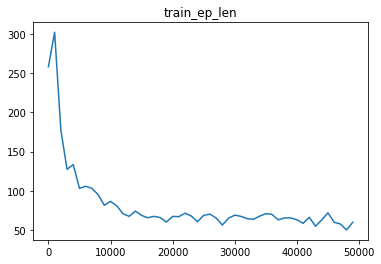

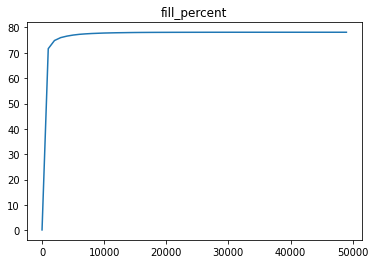

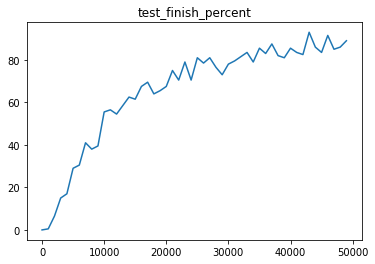

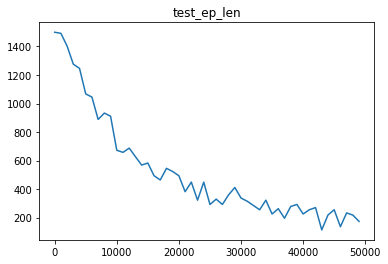

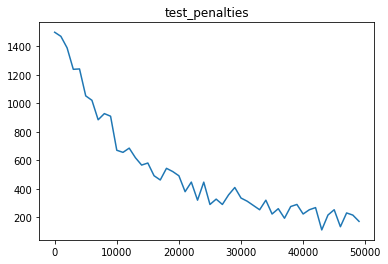

In [8]:
# The hyper-parameters of Q-learning
alpha = 0.1
gamma = 0.7
epsilon = 0.2
env = gym.make('DualTaxi-v1')
num_episodes = 50000

q_table = np.zeros([env.observation_space.n, env.action_space.n])
q_table, metrics = train_agent(q_table, env, num_episodes)
plot_metrics(metrics)

In [9]:
def play(q_table, env, num_episodes):
    frames=[]
    for i in range(num_episodes):
        state = env.reset()
        done = False
        while not done:
            next_action = np.argmax(q_table[state])
            state, reward, done, _ = env.step(next_action)
            frames.append({
                'frame': env.render(mode='ansi'),
                'state': state,
                'reward': reward,
                'episode': i + 1
                }
            )
    return frames

def print_frames(frames, speed=10):
    for frame in frames:
        clear_output(wait=True)
        print(f"Episode #{frame['episode']}")
        print(frame['frame'])
        print(f"State: {frame['state']}")
        print(f"Reward: {frame['reward']}")
        sleep(1/speed)

In [18]:
frames = play(q_table, env, 100)
print_frames(frames, speed=1)

Episode #2
+-------+
|R: | :G|
| : | : |
| | : : |
|Y: |B: |
+-------+
  (West)
  (West)

State: 300
Reward: -4


KeyboardInterrupt: 

In [10]:
def update_multi_agent(q_table1, q_table2, env, state):
    if random.uniform(0, 1) > epsilon:
        action = env.action_space.sample()
        action1, action2 = env.decode_action(action)
    else:
        action1 = np.argmax(q_table1[state])
        action2 = np.argmax(q_table2[state])
        action = env.encode_action(action1, action2)

    next_state, reward, done, info = env.step(action)
    reward1, reward2 = reward
    bellman_update(q_table1, state, action1, next_state, reward1)
    bellman_update(q_table2, state, action1, next_state, reward2)
    return next_state, reward, done, info


def train_multi_agent(
        q_table1, q_table2, env, num_episodes, log_every=50000, running_metrics_len=50000,
        evaluate_every=1000, evaluate_trials=200):

    rewards = deque(maxlen=running_metrics_len)
    episode_lengths = deque(maxlen=50)
    total_timesteps = 0

    metrics = {}

    for i in range(num_episodes):
        epochs = 0
        state = env.reset()
        done = False

        while not done:
            state, reward, done, info = update_multi_agent(q_table1, q_table2, env, state)
            rewards.append(sum(reward))
            epochs += 1
            total_timesteps += 1

            if total_timesteps % log_every == 0:
                rd = Counter(rewards)
                avg_ep_len = np.mean(episode_lengths)
                zeroes1, fill_percent1 = calculate_q_table_metrics(q_table1)
                zeroes2, fill_percent2 = calculate_q_table_metrics(q_table2)
                print(f'Current Episode: {i}')
                print(f'Reward distribution: {rd}')
                print(f'Last 10 episode lengths (avg: {avg_ep_len})')
                print(f'{zeroes1} Q table 1 zeroes, {fill_percent1} percent filled')
                print(f'{zeroes2} Q table 2 zeroes, {fill_percent2} percent filled')


        episode_lengths.append(epochs)

        if i % evaluate_every == 0:
            print('===' * 10)
            print(f"Running evaluation after {i} episodes")
            finish_percent, avg_time, penalties = evaluate_multi_agent(q_table1, q_table2, env, evaluate_trials)
            print('===' * 10)
            rd = Counter(rewards)
            avg_ep_len = float(np.mean(episode_lengths))
            zeroes1, fill_percent1 = calculate_q_table_metrics(q_table1)
            zeroes2, fill_percent2 = calculate_q_table_metrics(q_table2)

            metrics[i] = {
                    'train_reward_distribution': rd,
                    'train_ep_len': avg_ep_len,
                    'fill_percent1': fill_percent1,
                    'fill_percent2': fill_percent2,
                    'test_finish_percent': finish_percent,
                    'test_ep_len': avg_time,
                    'test_penalties': penalties
            }

    print("Training finished.\n")
    return q_table1, q_table2, metrics


def evaluate_multi_agent(q_table1, q_table2, env, num_trials):
    total_epochs, total_penalties, total_wins = 0, 0, 0

    for _ in range(num_trials):
        state = env.reset()
        epochs, num_penalties, wins = 0, 0, 0
        done = False
        while not done:
            next_action = env.encode_action(
                np.argmax(q_table1[state]),
                np.argmax(q_table2[state]))

            state, reward, done, _ = env.step(next_action)

            reward = sum(reward)

            if reward < -2:
                num_penalties += 1
            elif reward > 10:
                wins += 1

            epochs += 1
        total_epochs += epochs
        total_penalties += num_penalties
        total_wins += wins

    average_penalties, average_time, complete_percent = compute_evaluation_metrics(num_trials,total_epochs,total_penalties,total_wins)
    print_evaluation_metrics(average_penalties,average_time,num_trials,total_wins)
    return complete_percent, average_time, average_penalties

Total encoded states are 6144
Running evaluation after 0 episodes
Evaluation results after 200 trials
Average time steps taken: 1500.0
Average number of penalties incurred: 1500.0
Had 0 wins in 200 episodes
Current Episode: 77
Reward distribution: Counter({-4: 16149, -12: 14354, -3: 9080, -20: 4963, -11: 2625, -30: 2095, -2: 427, -10: 243, 99: 44, 90: 20})
Last 10 episode lengths (avg: 611.08)
15262 Q table 1 zeroes, 58.59917534722222 percent filled
15240 Q table 2 zeroes, 58.658854166666664 percent filled
Current Episode: 174
Reward distribution: Counter({-12: 16032, -4: 14794, -3: 8974, -20: 4744, -11: 2856, -30: 1683, -2: 596, -10: 232, 99: 73, 90: 16})
Last 10 episode lengths (avg: 391.96)
9757 Q table 1 zeroes, 73.53244357638889 percent filled
9769 Q table 2 zeroes, 73.49989149305556 percent filled
Current Episode: 304
Reward distribution: Counter({-12: 16943, -4: 14511, -3: 8673, -20: 4255, -11: 3043, -30: 1472, -2: 705, -10: 273, 99: 86, 90: 39})
Last 10 episode lengths (avg: 35

Current Episode: 6620
Reward distribution: Counter({-12: 16333, -4: 11560, -3: 10904, -11: 4177, -20: 3892, -30: 1490, -2: 811, -10: 356, 90: 264, 99: 213})
Last 10 episode lengths (avg: 102.04)
8064 Q table 1 zeroes, 78.125 percent filled
8064 Q table 2 zeroes, 78.125 percent filled
Running evaluation after 7000 episodes
Evaluation results after 200 trials
Average time steps taken: 791.855
Average number of penalties incurred: 788.515
Had 95 wins in 200 episodes
Current Episode: 7092
Reward distribution: Counter({-12: 16247, -4: 11391, -3: 11146, -11: 4230, -20: 3932, -30: 1445, -2: 783, -10: 362, 90: 245, 99: 219})
Last 10 episode lengths (avg: 92.96)
8064 Q table 1 zeroes, 78.125 percent filled
8064 Q table 2 zeroes, 78.125 percent filled
Current Episode: 7568
Reward distribution: Counter({-12: 16060, -3: 11638, -4: 10875, -11: 4267, -20: 3984, -30: 1563, -2: 792, -10: 354, 90: 267, 99: 200})
Last 10 episode lengths (avg: 99.22)
8064 Q table 1 zeroes, 78.125 percent filled
8064 Q ta

Evaluation results after 200 trials
Average time steps taken: 583.75
Average number of penalties incurred: 582.725
Had 123 wins in 200 episodes
Current Episode: 17200
Reward distribution: Counter({-12: 14622, -3: 12444, -4: 11171, -11: 4351, -20: 4025, -30: 1670, -2: 698, -10: 480, 90: 358, 99: 181})
Last 10 episode lengths (avg: 93.62)
8064 Q table 1 zeroes, 78.125 percent filled
8064 Q table 2 zeroes, 78.125 percent filled
Current Episode: 17783
Reward distribution: Counter({-12: 14957, -3: 12041, -4: 11514, -11: 4075, -20: 4008, -30: 1632, -2: 711, -10: 486, 90: 396, 99: 180})
Last 10 episode lengths (avg: 94.14)
8064 Q table 1 zeroes, 78.125 percent filled
8064 Q table 2 zeroes, 78.125 percent filled
Running evaluation after 18000 episodes
Evaluation results after 200 trials
Average time steps taken: 546.2
Average number of penalties incurred: 541.44
Had 128 wins in 200 episodes
Current Episode: 18334
Reward distribution: Counter({-12: 14799, -3: 12385, -4: 11156, -11: 4318, -20: 4

Running evaluation after 28000 episodes
Evaluation results after 200 trials
Average time steps taken: 509.365
Average number of penalties incurred: 508.35
Had 133 wins in 200 episodes
Current Episode: 28399
Reward distribution: Counter({-12: 14330, -3: 12764, -4: 11212, -11: 4241, -20: 4005, -30: 1748, -2: 666, -10: 500, 90: 343, 99: 191})
Last 10 episode lengths (avg: 84.04)
8064 Q table 1 zeroes, 78.125 percent filled
8064 Q table 2 zeroes, 78.125 percent filled
Current Episode: 28943
Reward distribution: Counter({-12: 14264, -3: 13041, -4: 11195, -11: 4307, -20: 3888, -30: 1611, -2: 651, -10: 520, 90: 351, 99: 172})
Last 10 episode lengths (avg: 95.12)
8064 Q table 1 zeroes, 78.125 percent filled
8064 Q table 2 zeroes, 78.125 percent filled
Running evaluation after 29000 episodes
Evaluation results after 200 trials
Average time steps taken: 621.215
Average number of penalties incurred: 620.315
Had 108 wins in 200 episodes
Current Episode: 29509
Reward distribution: Counter({-12: 143

Evaluation results after 200 trials
Average time steps taken: 576.125
Average number of penalties incurred: 575.26
Had 124 wins in 200 episodes
Current Episode: 39023
Reward distribution: Counter({-12: 13591, -3: 13532, -4: 10958, -11: 4368, -20: 3975, -30: 1792, -2: 661, -10: 566, 90: 388, 99: 169})
Last 10 episode lengths (avg: 84.56)
8064 Q table 1 zeroes, 78.125 percent filled
8064 Q table 2 zeroes, 78.125 percent filled
Current Episode: 39581
Reward distribution: Counter({-12: 14437, -3: 12702, -4: 11571, -20: 3936, -11: 3888, -30: 1727, -2: 624, -10: 568, 90: 385, 99: 162})
Last 10 episode lengths (avg: 85.22)
8064 Q table 1 zeroes, 78.125 percent filled
8064 Q table 2 zeroes, 78.125 percent filled
Running evaluation after 40000 episodes
Evaluation results after 200 trials
Average time steps taken: 427.11
Average number of penalties incurred: 426.085
Had 144 wins in 200 episodes
Current Episode: 40134
Reward distribution: Counter({-12: 13757, -3: 13697, -4: 10587, -11: 4522, -20:

Training finished.



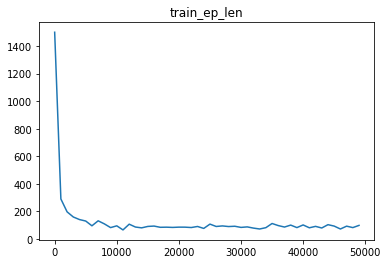

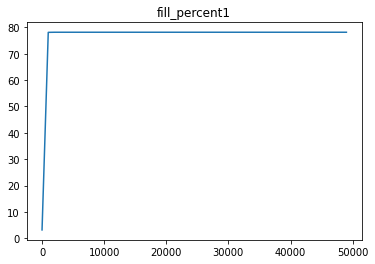

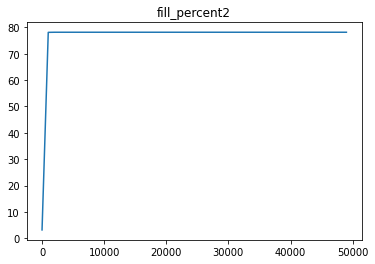

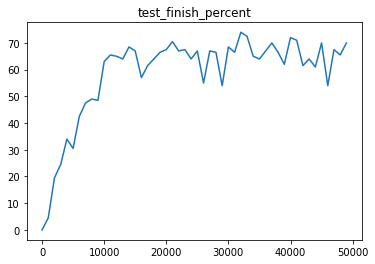

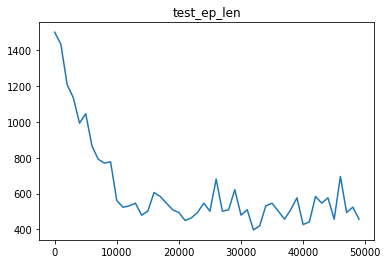

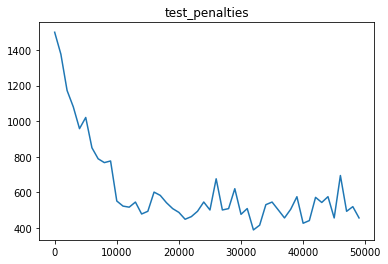

In [11]:
# The hyperparameter of Q-learning
alpha = 0.1
gamma = 0.7
epsilon = 0.2

env_c = gym.make('DualTaxi-v1', competitive=True)

num_episodes = 50000
q_table1 = np.zeros([env_c.observation_space.n, int(np.sqrt(env_c.action_space.n))])
q_table2 = np.zeros([env_c.observation_space.n, int(np.sqrt(env_c.action_space.n))])
q_table1, q_table2, metrics_c = train_multi_agent(q_table1, q_table2, env_c, num_episodes)
plot_metrics(metrics_c)

In [19]:
def play_multi(q_table1, q_table2, env, num_episodes):
    frames=[]
    for i in range(num_episodes):
        state = env.reset()
        done = False
        while not done:
            next_action = env.encode_action(
                np.argmax(q_table1[state]),
                np.argmax(q_table2[state]))
            state, reward, done, _ = env.step(next_action)
            frames.append({
                'frame': env.render(mode='ansi'),
                'state': state,
                'reward': reward,
                'episode': i + 1
                }
            )
    return frames


In [20]:
frames = play_multi(q_table1, q_table2, env_c, 10)
print_frames(frames, speed=1)

Episode #1
+-------+
|R: | :G|
| : | : |
| | : : |
|Y: |B: |
+-------+
  (East)
  (East)

State: 4300
Reward: (-2, -2)


KeyboardInterrupt: 